In [4]:
using LinearAlgebra
using Printf
using Polynomials
using Plots
using SparseArrays
using ToeplitzMatrices
using FiniteDifferences

global const µ = 3.986e14  # m^3/s^2

include("eval_f.jl")
include("forward_euler.jl")
include("trapezoidal.jl")

trapezoidal (generic function with 1 method)

### Make reduced order variables

In [40]:
function make_reduced_order(A, b, c, q)
    lambdas = eigvals(A);
    vectors = eigvecs(A);
    ass = size(A)
    
    Vq = zeros(ass[2], q);
#     n = size(vectors)
#     print(n)
    for i in 0:q-1
        print(q-i)
        Vq[:,i+1] = vectors[:,q-i]
    end    
    A_hat =  Vq' * A * Vq;
    b_hat = Vq' * b;
    c_hat = Vq' * c;
#     a = size(Vq)
    return A_hat, b_hat, c_hat, Vq
end

make_reduced_order (generic function with 1 method)

### transient reference function

In [20]:
function transient_ref(eval_f,x0,t_start,t_stop,n_time)

    ref_conf = zeros(length(n_time));
    (golden_x, golden_t) = euler(eval_f, t_start, t_stop, x0, n_time)

    X = Float64[];
#     time = time + dt;
    (temp, t_ref) = euler(eval_f, t_start, t_stop, x0, n_time)
    # add trapezoidal time integration here
    dims  = size(temp);
    print(dims[2])
#     print(temp[:,dims[2]])
    js dkfjsnf
    X = cat(X, temp[:,dims[2]], dims=(2,2));
    for n in -1:-.5:-4 
        dt  = 10^n;
        (temp, t_ref) = euler(eval_f, t_start, t_stop, x0, dt)
        # add trapezoidal time integration here
        dims  = size(temp2);
        X = cat(X, temp(dims[2]), dims=(2,2));
        r = max(abs(X[:,i] - X[:,i-1]))
        i = i+1;
        ref_conf[i-1] = r;
    end
    
    return X, ref_conf, t_ref
end

LoadError: syntax: "function" at In[20]:1 expected "end", got "dkfjsnf"

### trapezoidal method

In [46]:
function f(x)
    feval(x,0,0)
end

radius = 7e6;  # m
velocity = sqrt(µ/radius);


x0 = [radius, 0, 0, 0, velocity, 0];
t0 = 0;
ti = 2*pi*radius^1.5/µ^0.5;  # Should result in 1 orbit
num_steps = 1000;
xs = trapezoidal(f, t0, ti, x0, num_steps)

1001×6 Matrix{Float64}:
 7.0e6            0.0        0.0     0.0       7546.05  0.0
 6.99986e6    43981.9        0.0   -47.4128    7545.9   0.0
 6.99945e6    87962.0        0.0   -94.8236    7545.45  0.0
 6.99876e6        1.31939e5  0.0  -142.231     7544.71  0.0
 6.99779e6        1.7591e5   0.0  -189.632     7543.67  0.0
 6.99655e6        2.19875e5  0.0  -237.026     7542.33  0.0
 6.99503e6        2.6383e5   0.0  -284.411     7540.69  0.0
 6.99323e6        3.07776e5  0.0  -331.784     7538.75  0.0
 6.99116e6        3.51709e5  0.0  -379.145     7536.52  0.0
 6.98881e6        3.95628e5  0.0  -426.49      7533.99  0.0
 6.98619e6        4.39532e5  0.0  -473.819     7531.16  0.0
 6.98329e6        4.83419e5  0.0  -521.129     7528.03  0.0
 6.98011e6        5.27286e5  0.0  -568.418     7524.61  0.0
 ⋮                                                      ⋮
 6.98328e6       -4.83563e5  0.0   521.284     7528.02  0.0
 6.98618e6       -4.39677e5  0.0   473.974     7531.15  0.0
 6.9888e6        -

Final energy / initial energy: 0.9999999999999998
(101, 6)

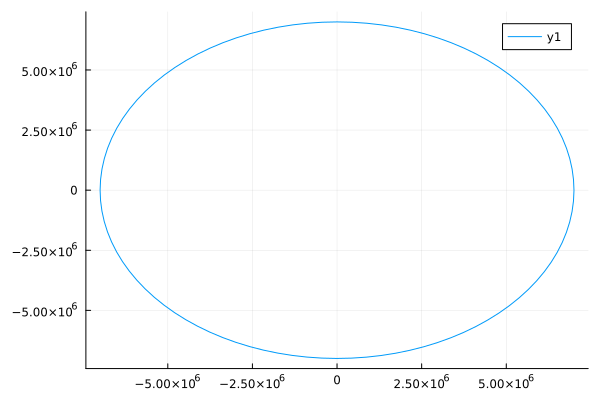

In [57]:
println("Final energy / initial energy: ",energy(x0)/energy(xs[num_steps+1,:]))
print(size(xs))
plot(xs[:,1], xs[:,2])

# NOTES: Implementation issues
Ideally, the validity of the solutions for the full system and its reduced order counterparts would be evaluated with the transient reference method, and the reference confidence can be used to determine how trustable the final states for the system are

In [105]:
num_steps = 6
N = 100
A = zeros(num_steps, num_steps)
A[num_steps,1] = -1; A[1,num_steps] = -1;
for i in 1:num_steps
    A[i,i] = 2
    if i < num_steps
        A[i,i+1] = -1
    end
    if i > 1
        A[i,i-1] = -1
    end
end
b = zeros(num_steps); #should just be zero
c = zeros(num_steps);
c[num_steps] = 1;

q = [5,10];
for i in 1:length(q)
#     new_x0 = zeros(q[i]);
#     if q[i] > length(x0)
#         maxi = length(x0);
#     else
#         maxi = q[i];
#     end
#     for j in 1:maxi
#         new_x0[j] = x0[j];
#     end
    (A_hat, b_hat, c_hat, Vq) = make_reduced_order(A,b,c,q[i]);
    A_hat
    b_hat
    c_hat
    Vq
#     new_xs = A_hat * new_x0;
#     print(new_xs)
    xs = trapezoidal(f, t0, ti, x0, N)
    dims = size(xs)
    print("\n")
    print(dims[2])
    y_hat = zeros(length(xs[1,:]))
    for j in 1:length(xs[1,:])
        y_hat[j] = c_hat' * xs[:,j];
    end
    plot(xs[:,1], xs[:,2])
end

# plot(xs[:,1], xs[:,2])

### function evolution over time

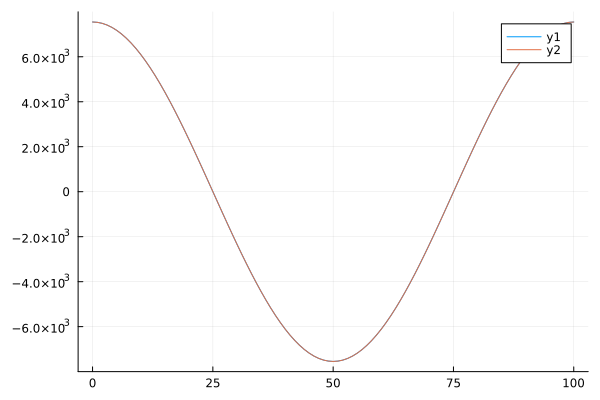

In [104]:
dt = (ti - t0)/num_steps;
z = zeros(length(xs[:,1]));
for i in 0:length(xs[:,1])-1
    z[i+1] = i;
end
plot(z,xs[:,5])
# for t = t0:dt:ti
    dims = size(xs)
   plot!(z,xs[:,dims[2]-1])
# end